### Creating a list of window coordiantes

Extent:  
99000,6702000 : 402000,6882000

In [134]:
im_path_spot_2 = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [136]:
def get_spatial_extent(filepath):
    """
    Takes filepath, returns bounding box
    """
    
    import rasterio
    with rasterio.open(filepath) as src:
        bbox = src.bounds
    return(bbox)

In [137]:
def create_window_coordinates(filepath,window_size=500,clip=False):
    """
    Inputs:
        - fiepath: path of raster that is to be loaded by window
        - window_size: window will be pixel size NxN
        - clip: specify if every grid point should be sampled and dropped if value is invalid
    Outputs:
        - list of tuple coordinates of grid points (in CRS of input raster)
    Takes filepath, creates grid of coordinate points in wanted window size.
    (sampling of points bc mask reads whole into RAM)
    """
    
    # get bbox
    bbox = get_spatial_extent(filepath)
    left = int(bbox[0])
    bottom = int(bbox[1])
    right = int(bbox[2])
    top = int(bbox[3])
    
    # iterate in 500 steps over image bounds, create grid
    coor = []
    for i in range(left,right,window_size):
        x = i
        for j in range(bottom,top,window_size):
            y = j
            coor.append((x,y))
    
    
    """
    PERFORM CLIP
    """
    if clip:
        import geopandas
        import pandas as pd
        import rasterio
        # load into gdf
        print("performing clip of window corner points to valid raster values!\nloading points into gdf...")
        df = pd.DataFrame(coor,columns=["x","y"])
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))

        print("sampling points on raster...")
        with rasterio.open(filepath) as src:
            gdf['value'] = [sum(x) for x in src.sample(coor)]
        
        print("dropping invalid points...")
        # drop invalid points and useless columns
        gdf = gdf.drop(gdf[gdf.value <= 0].index)
        # create new list of tuples to return
        coor = []
        for x_,y_ in zip(gdf["x"],gdf["y"]):
            coor.append((x_,y_))
        print("clipping done!")
    
    return(coor)


In [138]:
def extract_spot6_window(filepath,coordinates,window_size=500,show=False):
    
    import rasterio
    import numpy as np
    
    # if coordinates == singular tuple of coordinates, wrap it in list
    if type(coordinates)!=list:
        coordinates = [coordinates]
    
    with rasterio.open(filepath) as dataset:
        # Loop through your list of coords
        for i, (lon, lat) in enumerate(coordinates):

            # Get pixel coordinates from map coordinates
            py, px = dataset.index(lon, lat)
            #print('Pixel Y, X coords: {}, {}'.format(py, px))

            # Build an NxN window (centered)
            window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
            #print(window)

            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = dataset.read(window=window)
            
            if show:
                if clip.shape == (3, 500, 500):
                    image_standard_form = np.transpose(clip, (2, 1, 0))
                    plt.imshow(image_standard_form)
                    plt.show()
                else:
                    print("Shape invalid - most likely edge window")
            
            
            """
            if save_file:
                # Set Meta of new file
                meta = dataset.meta
                meta['width'], meta['height'] = N, N
                meta['transform'] = rasterio.windows.transform(window, dataset.transform)

                with rasterio.open(outfile.format(i), 'w', **meta) as dst:
                    dst.write(clip)
            """
            
    return(clip)


In [139]:
# get coordinates
coordinates = create_window_coordinates(im_path_spot_2,window_size=500,clip=True)

performing clip of window corner points to valid raster values!
loading points into gdf...
sampling points on raster...
dropping invalid points...
clipping done!


In [140]:
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_collection/sen2/closest_dates.pkl"

def get_closest_date(coordinates,closest_dates_filepath):
    import geopandas
    import fiona
    import pandas as pd
    
    print("create closest dates gdf")
    # load and transform closest dates dataframe
    df = pd.read_pickle(closest_dates_filepath)
    closest_dates = geopandas.GeoDataFrame(df, geometry=df.geom,crs=2154)
    del df

    print("create coordinates gdf")
    # create coordinates gdf
    x,y = [],[]
    for i in coordinates:
        x.append(i[0])
        y.append(i[1])
    coordinates_df = pd.DataFrame()
    coordinates_df["x"] = x
    coordinates_df["y"] = y
    coordinates_df = geopandas.GeoDataFrame(coordinates_df, geometry=geopandas.points_from_xy(coordinates_df.x, coordinates_df.y),crs=2154)
    
    print("perform spatial join")
    # spatial join for coordinates
    coordinates_joined_date = coordinates_df.sjoin(closest_dates, how="left")
    print("done")
    
    return(coordinates_joined_date)
    
a = get_closest_date(coordinates,closest_dates_filepath)

create closest dates gdf
create coordinates gdf
perform spatial join
done


In [141]:
a

,x,y,geometry,index_right,name,min,max,other_acq,geom
0,99000,6843500,POINT (99000.000 6843500.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684..."
1,99000,6844000,POINT (99000.000 6844000.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684..."
2,99000,6844500,POINT (99000.000 6844500.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684..."
3,99000,6845000,POINT (99000.000 6845000.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684..."
4,99000,6845500,POINT (99000.000 6845500.000),1967,ORT_2018_0099_6846_LA93_8Bits.jp2,1,144,"{33: [2018-04-03 00:00:00, 'SENTINEL2A_2018040...","POLYGON ((99000.000 6846000.000, 99000.000 684..."
...,...,...,...,...,...,...,...,...,...
120603,401500,6829000,POINT (401500.000 6829000.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6..."
120604,401500,6829500,POINT (401500.000 6829500.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6..."
120605,401500,6830000,POINT (401500.000 6830000.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6..."
120606,401500,6830500,POINT (401500.000 6830500.000),3334,ORT_2018_0399_6831_LA93_8Bits.jp2,1,159,"{159: [2018-09-26 00:00:00, 'SENTINEL2B_201809...","POLYGON ((399000.000 6831000.000, 399000.000 6..."


### test spot6 window extraction

In [127]:
%%timeit
extract_spot6_window(im_path_spot_2,coordinates[50001],window_size=500,show=False)

169 ms ± 9.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


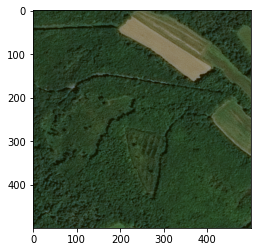

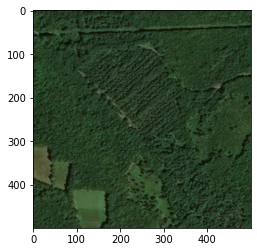

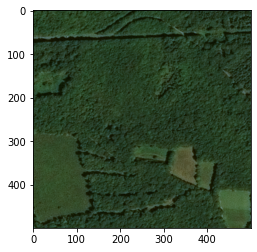

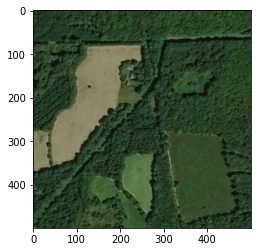

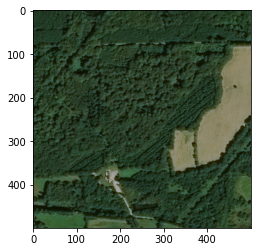

array([[[31, 27, 23, ..., 46, 49, 49],
        [30, 30, 27, ..., 45, 50, 46],
        [35, 35, 34, ..., 43, 51, 50],
        ...,
        [33, 30, 33, ..., 26, 27, 36],
        [36, 34, 38, ..., 26, 31, 44],
        [36, 36, 44, ..., 29, 37, 44]],

       [[54, 46, 37, ..., 71, 73, 76],
        [53, 48, 46, ..., 68, 77, 74],
        [60, 59, 59, ..., 67, 80, 77],
        ...,
        [60, 51, 58, ..., 31, 35, 53],
        [65, 60, 67, ..., 35, 43, 64],
        [66, 66, 78, ..., 38, 54, 69]],

       [[34, 24, 13, ..., 49, 56, 58],
        [31, 27, 22, ..., 48, 61, 56],
        [42, 41, 39, ..., 46, 63, 60],
        ...,
        [27, 19, 28, ...,  4,  6, 22],
        [37, 30, 43, ...,  6, 15, 39],
        [38, 39, 56, ...,  9, 25, 45]]], dtype=uint8)

In [128]:
extract_spot6_window(im_path_spot_2,coordinates[50000:50005],window_size=500,show=True)

In [89]:
b = []
for i in a["other_acq"]:
    b.append(len(i))
print("Min number of extra Sen2 acq.: ",min(b))

Min number of extra Sen2 acq.:  8


## Sen2 Check if windows are valid

In [116]:
def create_sen2_validity_dataframe(df):
    count=0
    print("Checking Sen2 validity for all windows & acquisitions")
    ls_dict = []
    for dic,x,y in zip(df["other_acq"],df["x"],df["y"]):
        dic_keys = dic.keys()
        for i in list(dic_keys):
            #print(i)
            file = dic[i][1]
            filepath = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"+file
            #print(test_sen2_window(filepath,(x,y),window_size=50,show=False))
            dic[i].append(test_sen2_window(filepath,(x,y),window_size=50,show=False))
        ls_dict.append(dic)
        
        count=count+1
        if count%100==0:
            perc = round(100 * float(count)/float(len(df)),2)
            print(str(perc),"%",end="\r")
    
    df["other_valid_acq"]=ls_dict
    return(df)


def test_sen2_window(filepath,coordinates,window_size=100,show=True):
    """
    Inputs:
        - filepath of mosaic raster
        - point coordinates of window
        - window size in pixels
    Outputs:
        - window array from input mosaic at desired location
    
    """
    import rasterio
    import numpy as np

     # if coordinates == singular tuple of coordinates, wrap it in list
    if type(coordinates)!=list:
        coordinates = [coordinates]

    with rasterio.open(filepath) as dataset:
        # Loop through your list of coords
        for i, (lon, lat) in enumerate(coordinates):

          # Get pixel coordinates from map coordinates
            py, px = dataset.index(lon, lat)
            #print('Pixel Y, X coords: {}, {}'.format(py, px))

            # Build an NxN window (centered)
            window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
            #print(window)

            # Read the data in the window
            # clip is a nbands * N * N numpy array
            clip = dataset.read(window=window)

            if clip.shape == (3, window_size, window_size) and np.average(clip)>0.1:
                validity = True
                    
                if show: # show image
                    image_standard_form = np.transpose(clip, (2, 1, 0))
                    #print(type(image_standard_form))
                    plt.imshow(image_standard_form)
                    plt.show()
            else:
                validity = False

    return(validity)

In [ ]:
# get gdf of points with info on validity os sen2
res = create_sen2_validity_dataframe(a)

## Test sen2 and spot6 window extraction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


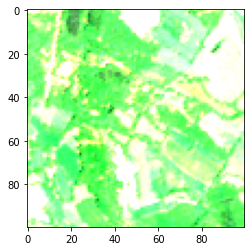

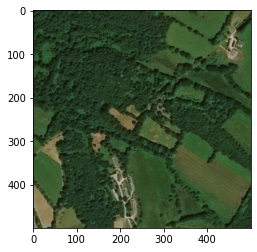

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


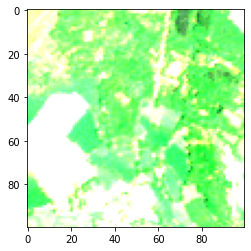

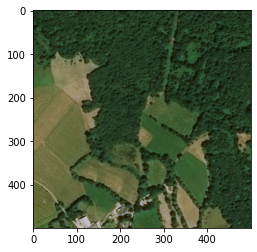

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


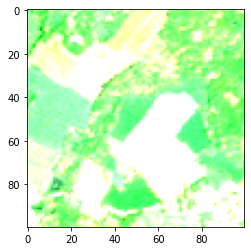

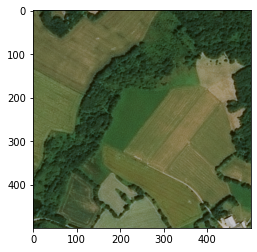

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


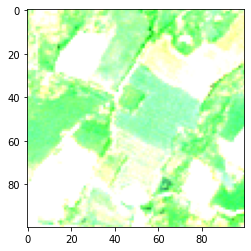

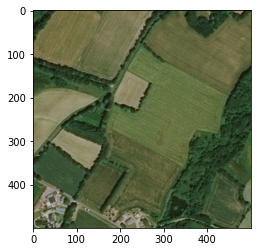

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


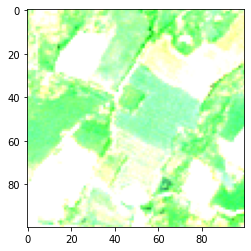

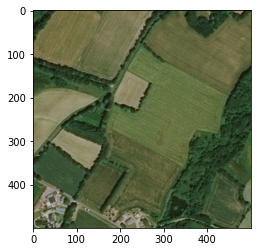

CPU times: user 3.65 s, sys: 1.79 s, total: 5.44 s
Wall time: 3.54 s


In [147]:

for x,y,dic in zip(a["x"][50000:50005],a["y"][50000:50005],a["other_acq"][50000:50005]):
    dic_keys = dic.keys()
    for i in list(dic_keys):
        file = dic[i][1]
        filepath = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"+file
        
        test_sen2_window(filepath,(x,y),window_size=100,show=True)
        break
    extract_spot6_window(im_path_spot_2,(x,y),window_size=500,show=True)

In [149]:
%%timeit
for x,y,dic in zip(a["x"][50000:50001],a["y"][50000:50001],a["other_acq"][50000:50001]):
    dic_keys = dic.keys()
    for i in list(dic_keys):
        file = dic[i][1]
        filepath = "/home/simon/CDE_UBS/thesis/data_collection/sen2/merged_reprojected/"+file
        
        test_sen2_window(filepath,(x,y),window_size=100,show=False)
        break
    extract_spot6_window(im_path_spot_2,(x,y),window_size=500,show=False)

191 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Define DataSet Class

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

In [13]:
# inputs
im_path_spot_2 = '/home/simon/CDE_UBS/thesis/data_collection/spot6/spot6_mosaic.tif'
closest_dates_filepath = "/home/simon/CDE_UBS/thesis/data_collection/sen2/closest_dates.pkl"

In [122]:
# Define torch dataset Class
class Dataset(Dataset):
    def __init__(self,path,closest_dates_filepath,window_size=500,clip=False):
        # define raster filepath
        self.path = path
        # define window size
        self.window_size = window_size
        # create list of xy coordinates spaced according to window size over raster
        self.coordinates = Dataset.create_window_coordinates(self.path,window_size=self.window_size,clip=clip)
        # get closest sen2 acq. date for each datapoint
        self.coordinates_closest_date = Dataset.get_closest_date(self.coordinates,closest_dates_filepath)
        
 
    def __len__(self):
        # returns length
        return(len(self.coordinates))
 
    def __getitem__(self,idx):
        # extract coordinates of current request
        current_coor = self.coordinates[idx]
        
        # load spot6 window
        im_spot6 = Dataset.extract_spot6_window(self.path,coordinates=current_coor,window_size=self.window_size)
        
        """
        EXTRACT ONE CLOSEST DATE
        """
        # get according sen2 image
        # extract line from df that corresponds to this point
        #print(current_coor)
        #tmp1 = self.coordinates_closest_date[self.coordinates_closest_date["x"] == current_coor[0]]
        #print(tmp1)
        #tmp2 = tmp1[tmp1["y"] == current_coor[1]]
        #print(tmp2)
        #dates_dict = tmp2["other_acq"][0]
        #print(dates_dict)
        #print("value error")
        

        # return extracted images
        return(im_spot6)
    
    def extract_spot6_window(filepath,coordinates,window_size=500,show=False):
        """
        Inputs:
            - filepath of mosaic raster
            - point coordinates of window
            - window size in pixels
        Outputs:
            - window array from input mosaic at desired location
        
        """
        import rasterio
        import numpy as np

        # if coordinates == singular tuple of coordinates, wrap it in list
        if type(coordinates)!=list:
            coordinates = [coordinates]

        with rasterio.open(filepath) as dataset:
            # Loop through your list of coords
            for i, (lon, lat) in enumerate(coordinates):

                # Get pixel coordinates from map coordinates
                py, px = dataset.index(lon, lat)
                #print('Pixel Y, X coords: {}, {}'.format(py, px))

                # Build an NxN window (centered)
                window = rasterio.windows.Window(px - window_size//2, py - window_size//2, window_size, window_size)
                #print(window)

                # Read the data in the window
                # clip is a nbands * N * N numpy array
                clip = dataset.read(window=window)

                if show:
                    if clip.shape == (3, window_size, window_size):
                        image_standard_form = np.transpose(clip, (2, 1, 0))
                        plt.imshow(image_standard_form)
                        plt.show()
                    else:
                        print("Shape invalid - most likely edge window")


                """
                if save_file:
                    # Set Meta of new file
                    meta = dataset.meta
                    meta['width'], meta['height'] = N, N
                    meta['transform'] = rasterio.windows.transform(window, dataset.transform)

                    with rasterio.open(outfile.format(i), 'w', **meta) as dst:
                        dst.write(clip)
                """

        return(clip)
    
    def create_window_coordinates(filepath,window_size=500,clip=False):
        """
        Inputs:
            - fiepath: path of raster that is to be loaded by window
            - window_size: window will be pixel size NxN
            - clip: specify if every grid point should be sampled and dropped if value is invalid
        Outputs:
            - list of tuple coordinates of grid points (in CRS of input raster)
        Takes filepath, creates grid of coordinate points in wanted window size.
        (sampling of points bc mask reads whole into RAM)
        """

        # get bbox
        bbox = Dataset.get_spatial_extent(filepath)
        left = int(bbox[0])
        bottom = int(bbox[1])
        right = int(bbox[2])
        top = int(bbox[3])

        # iterate in N=window_size steps over image bounds, create grid
        coor = []
        for i in range(left,right,window_size):
            x = i
            for j in range(bottom,top,window_size):
                y = j
                coor.append((x,y))


        """
        PERFORM CLIP
        """
        if clip:
            import geopandas
            import pandas as pd
            import rasterio
            # load into gdf
            print("Performing clip of window corner points to valid raster values!\nloading points into gdf...")
            df = pd.DataFrame(coor,columns=["x","y"])
            gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.x, df.y))

            print("verifying points on raster...")
            with rasterio.open(filepath) as src:
                gdf['value'] = [sum(x) for x in src.sample(coor)]

            print("dropping invalid points...")
            # drop invalid points and useless columns
            gdf = gdf.drop(gdf[gdf.value <= 0].index)
            # create new list of tuples to return
            coor = []
            for x_,y_ in zip(gdf["x"],gdf["y"]):
                coor.append((x_,y_))
            print("clipping done!\n")

        return(coor)

    def get_spatial_extent(filepath):
        """
        Takes filepath, returns bounding box
        """

        import rasterio
        with rasterio.open(filepath) as src:
            bbox = src.bounds
        return(bbox)
    
    def get_closest_date(coordinates,closest_dates_filepath):
        import geopandas
        import fiona
        import pandas as pd
        
        print("Getting closest dates!")
        print("create closest dates gdf")
        # load and transform closest dates dataframe
        df = pd.read_pickle(closest_dates_filepath)
        closest_dates = geopandas.GeoDataFrame(df, geometry=df.geom,crs=2154)
        del df

        print("create coordinates gdf")
        # create coordinates gdf
        x,y = [],[]
        for i in coordinates:
            x.append(i[0])
            y.append(i[1])
        coordinates_df = pd.DataFrame()
        coordinates_df["x"] = x
        coordinates_df["y"] = y
        coordinates_df = geopandas.GeoDataFrame(coordinates_df, geometry=geopandas.points_from_xy(coordinates_df.x, coordinates_df.y),crs=2154)

        print("perform spatial join")
        # spatial join for coordinates
        coordinates_joined_date = coordinates_df.sjoin(closest_dates, how="left")
        print("done\n")

        return(coordinates_joined_date)

In [123]:
# Instanciate dataset object
dataset = Dataset(im_path_spot_2,closest_dates_filepath,window_size=500,clip=True)

Performing clip of window corner points to valid raster values!
loading points into gdf...
verifying points on raster...
dropping invalid points...
clipping done!

Getting closest dates!
create closest dates gdf
create coordinates gdf
perform spatial join
done



In [124]:
# Instanciate dataloader object
loader = DataLoader(dataset,batch_size=1, shuffle=True, num_workers=1)
print("Loader Length: ",len(loader))

Loader Length:  120608


In [132]:
_ = dataset.__getitem__(50000)

In [133]:
%%timeit
_ = dataset.__getitem__(50000)

170 ms ± 6.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
